# Exploring parameters

#### density plots, post predictive checks etc.

In [1]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
#sys.path.append('../code/sbi/')
#sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

os.chdir(work_dir)

#from utils.plot import cov, compare_vars, plot_varchanges
#from utils.plot import compare_KLs, plot_KLs
#from sbi.inference import potentials
import utils.sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


In [2]:
print(torch.__version__)

1.11.0


In [3]:
## defining neuronal network model

num_params = 6

from utils.simulation_wrapper import set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(num_params, noise=False)


In [5]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/'

os.chdir(work_dir)



import os

print(os.getcwd())



file = 'toy_example_maf_08_04_lesser_ratio'
file ='toy_example_version2_maf_02_05_long'



print(os.getcwd())

os.chdir('results/{}'.format(file))


print(os.getcwd())
  



/home/ubuntu
/home/ubuntu
/home/ubuntu/results/toy_example_version2_maf_02_05_long


In [6]:
def Gaussian(thetas, normal_noise=1):
    
    gauss_list = []
    
    for theta in thetas:
    
        mu, sigma = theta, normal_noise # mean and standard deviation

        s = np.random.normal(mu, sigma, 1)
    
        
        gauss_list.append(s[0])
        
    gauss_obs = torch.tensor(gauss_list)
    
    return gauss_obs
    



In [7]:
list_collection = torch.load('list_collection.pt')
list_collection_inc = torch.load('list_collection_inc.pt')

In [8]:
true_thetas = torch.tensor([[3.0, 6.0, 20.0, 10.0, 90.0, 55.0, 27.0, 27.0, 4.0, 70.0, 5.0, 66.0, 99.0, 40.0, 45.0]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

prior_max = [100.0] * 15
prior_min = [1.0] * 15

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)

samples_prior = prior.sample((10000,))

simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

In [9]:
samples_prior_list = samples_prior.unsqueeze(0)

In [10]:
samples_prior_list[0].shape

torch.Size([10000, 15])

In [11]:
thetas = inference.run_only_sim(samples_prior_list, simulation_wrapper = simulator_stats, num_workers=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished


In [12]:
def KL_Gauss(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)

    var_y = Y.stddev

    mu_y = Y.mean
    
    
    return torch.mean(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)), var_x, mu_x


def calc_KL_1d(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)
    
    print(var_x)
    print(mu_x)


    var_y = Y.stddev

    mu_y = Y.mean
    
    print(mu_y)
    print(var_y)
    
    print(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2))
    
    return np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)


# calculate the jensen-shanon divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [13]:

analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_snpe_list = []

variance_list_snpe = []

mean_list_snpe = []


## for round
for posterior_snpe_list in list_collection:
    
    KL_snpe = []
    KL_snpe_1d = []
    
    
    ## for number of simulations
    for posterior_snpe in posterior_snpe_list:


        #KL = KLdivergence(posterior_snpe, sample_y)
        KL, var_x, mu_x = KL_Gauss(posterior_snpe, analytic)
        
        variance_list_snpe.append(var_x)
        
        mean_list_snpe.append(mu_x)


        KL_1d = calc_KL_1d(posterior_snpe, analytic)

        KL_snpe_1d.append(KL_1d)

        #KL_snpe_sum.append(sum_KL)

        KL_snpe.append(KL)
        
    overall_snpe_list.append(KL_snpe)


    
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.064
acceptance rate:  0.07354545454545454
acceptance rate:  0.07238095238095238


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.076
acceptance rate:  0.07127272727272728
acceptance rate:  0.072
tensor([4.5124, 6.3300, 4.7843, 4.4485, 5.2681, 2.6619, 4.6962, 4.1342, 5.2766,
        5.2658, 4.1375, 3.8126, 5.1213, 3.2066, 3.1499])
tensor([ 7.0829, 11.2084, 29.8048,  9.1404, 87.4962, 54.2090, 24.6163, 26.2224,
         8.5105, 68.2251,  7.1947, 62.8192, 92.4909, 39.6988, 46.7969])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[16.5090, 31.2529, 57.4460,  8.2716, 14.8492,  2.3767, 11.8213,  6.9289,
         21.9301, 13.2780,  9.0475, 10.4885, 32.1648,  3.5213,  4.9280]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.013
acceptance rate:  0.013545454545454546
acceptance rate:  0.013333333333333334
acceptance rate:  0.012774193548387098
acceptance rate:  0.01273170731707317
acceptance rate:  0.012725490196078432
acceptance rate:  0.012295081967213115
acceptance rate:  0.012492957746478872
acceptance rate:  0.012493827160493827


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.011
acceptance rate:  0.012545454545454545
acceptance rate:  0.012
acceptance rate:  0.011903225806451614
acceptance rate:  0.011951219512195122
acceptance rate:  0.01223529411764706
acceptance rate:  0.012180327868852458
acceptance rate:  0.012140845070422535
acceptance rate:  0.012333333333333333
acceptance rate:  0.012296703296703296
tensor([2.6019, 3.6228, 4.5222, 4.0912, 3.5900, 2.8170, 3.0753, 2.8798, 3.8603,
        3.8564, 4.0181, 2.3350, 3.0943, 2.2813, 2.1144])
tensor([ 4.2669,  6.3080, 12.1889,  9.7714, 93.6580, 59.5253, 22.6989, 29.6538,
        11.0014, 67.8993,  6.8488, 67.8390, 95.7602, 39.8895, 44.2319])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.7312,  4.8227, 38.7223,  6.4863, 11.3564, 12.6711, 12.3553,  6.1100,
         30.1098,  7.7926,  7.8908,  3.0690,  8.4060,  1.2835,  1.2815]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.007


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 923 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.007
acceptance rate:  0.007904761904761904
acceptance rate:  0.007870967741935483
acceptance rate:  0.007780487804878049
acceptance rate:  0.007568627450980392
acceptance rate:  0.007409836065573771
acceptance rate:  0.007507042253521127
acceptance rate:  0.007320987654320987
acceptance rate:  0.007494505494505494
acceptance rate:  0.007475247524752475
acceptance rate:  0.007603603603603603
acceptance rate:  0.007677685950413223
acceptance rate:  0.007717557251908397


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.012


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 912 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.008
acceptance rate:  0.008476190476190476
acceptance rate:  0.00867741935483871
acceptance rate:  0.008487804878048781
acceptance rate:  0.008588235294117647
acceptance rate:  0.008377049180327868
acceptance rate:  0.008408450704225351
acceptance rate:  0.008234567901234568
acceptance rate:  0.008164835164835165
acceptance rate:  0.008198019801980198
acceptance rate:  0.00818018018018018
acceptance rate:  0.008247933884297521
acceptance rate:  0.008221374045801528
tensor([2.7119, 3.4786, 4.8799, 4.6504, 4.2338, 2.3084, 3.5579, 3.4926, 3.8427,
        2.5026, 4.6525, 2.9853, 3.5295, 2.3980, 2.6170])
tensor([ 4.4428,  5.7523, 18.0021, 21.6999, 92.4884, 55.4173, 30.7561, 31.4663,
         6.8994, 71.6208,  8.4441, 64.1235, 94.6338, 36.1627, 42.6352])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 3.2204,  4.3342, 11.8177, 77.2196, 10.1157,  

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.094
acceptance rate:  0.0839090909090909
acceptance rate:  0.08166666666666667


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.094
acceptance rate:  0.08372727272727273
acceptance rate:  0.08271428571428571
tensor([4.2387, 3.8128, 2.6880, 4.5934, 3.6500, 2.4411, 3.3444, 2.6505, 4.5007,
        2.3230, 3.9982, 2.4485, 3.2316, 2.2684, 2.1399])
tensor([ 9.1369,  7.5309, 24.0385, 16.4257, 85.6641, 57.2896, 30.6566, 26.1369,
         9.9465, 70.4587,  7.7420, 65.0703, 95.7828, 38.3544, 45.0109])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[25.8699,  6.6021, 10.2787, 29.1698, 14.2665,  4.2082, 10.5707,  2.4103,
         25.8042,  1.4605,  9.8661,  2.0343,  8.7237,  2.6076,  1.0289]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.177
acceptance rate:  0.18263636363636362


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.157
acceptance rate:  0.17927272727272728
tensor([4.0085, 4.9464, 4.0927, 4.1077, 3.6720, 1.9934, 2.9093, 2.6044, 2.8747,
        2.9606, 3.3102, 2.4154, 4.0559, 2.2090, 2.0469])
tensor([ 9.5325, 13.2540, 24.7675, 11.7259, 87.6011, 54.9746, 29.8842, 25.4655,
         8.8311, 67.4866,  6.0952, 64.1442, 94.5328, 38.9813, 48.0336])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[27.4825, 36.4448, 17.8304,  8.0132,  7.8184,  0.7973,  6.8233,  3.1116,
         14.2456,  5.9557,  4.3814,  3.2572, 16.3033,  1.6661,  5.4798]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.529
acceptance rate:  0.5355454545454545


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.54
acceptance rate:  0.5319090909090909
tensor([8.1516, 5.4701, 3.0995, 3.5014, 4.3709, 2.1608, 3.2908, 3.1179, 4.5638,
        3.2388, 5.9817, 3.1394, 7.4956, 2.1318, 1.8585])
tensor([18.3997,  9.3866, 20.2097, 10.6161, 84.0738, 57.6548, 28.1499, 29.6574,
         9.6181, 68.1475, 13.6032, 61.8653, 84.7237, 36.6586, 44.6432])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[149.2019,  18.4963,   3.1943,   4.5665,  25.1372,   4.5880,   4.3847,
           6.7544,  24.1773,   5.2855,  52.6089,  11.8316, 127.4839,   6.5976,
           0.6709]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.113
acceptance rate:  0.115


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.105
acceptance rate:  0.10818181818181818
tensor([5.0224, 3.1242, 4.2592, 6.4239, 4.6299, 2.6879, 3.8506, 4.0359, 5.4571,
        3.0272, 4.9080, 2.8673, 4.9572, 3.3184, 2.9207])
tensor([10.5626,  4.8727, 24.9610, 17.5406, 87.3159, 54.8396, 29.5845, 27.4751,
        10.6426, 67.5595,  9.9859, 60.6957, 90.3303, 44.3315, 43.5422])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[39.0947,  3.8766, 19.4272, 46.7035, 12.2876,  2.1364,  8.9052,  6.3617,
         34.7556,  5.9522, 22.3834, 16.6252, 47.7677, 13.1872,  3.7560]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.393
acceptance rate:  0.3698181818181818


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.362
acceptance rate:  0.362
tensor([4.9235, 4.0358, 3.4785, 4.0375, 3.7794, 2.4673, 3.3120, 3.0236, 4.4450,
        2.4726, 5.2004, 2.1134, 3.8663, 1.9192, 2.0226])
tensor([10.7151,  7.0547, 20.6684, 12.2237, 86.3328, 54.9365, 31.4686, 28.9168,
        13.8743, 69.6022, 14.3087, 60.2530, 94.2020, 40.0831, 45.5256])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[39.7878,  6.8049,  4.5268,  8.7275, 12.0364,  1.6426, 13.7712,  4.8018,
         56.6382,  1.7307, 54.6989, 17.4992, 17.1321,  0.6933,  0.9791]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.006


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 932 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0061818181818181816
acceptance rate:  0.0058095238095238096
acceptance rate:  0.005387096774193549
acceptance rate:  0.0052439024390243906
acceptance rate:  0.005
acceptance rate:  0.004819672131147541
acceptance rate:  0.004830985915492958
acceptance rate:  0.004790123456790123
acceptance rate:  0.004923076923076923
acceptance rate:  0.0048514851485148515
acceptance rate:  0.0048378378378378375
acceptance rate:  0.004760330578512397
acceptance rate:  0.004770992366412214
acceptance rate:  0.004851063829787234
acceptance rate:  0.004887417218543046
acceptance rate:  0.004894409937888199
acceptance rate:  0.004883040935672514
acceptance rate:  0.004917127071823205
acceptance rate:  0.0048900523560209425
acceptance rate:  0.004845771144278607
acceptance rate:  0.004829383886255924


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.005


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 945 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.005
acceptance rate:  0.004523809523809524
acceptance rate:  0.004451612903225806
acceptance rate:  0.004121951219512195
acceptance rate:  0.004254901960784313
acceptance rate:  0.004475409836065574
acceptance rate:  0.004478873239436619
acceptance rate:  0.004518518518518519
acceptance rate:  0.0045164835164835165
acceptance rate:  0.0045148514851485145
acceptance rate:  0.0045315315315315316
acceptance rate:  0.004537190082644628
acceptance rate:  0.004541984732824428
acceptance rate:  0.004531914893617021
acceptance rate:  0.004529801324503311
acceptance rate:  0.004608695652173913
acceptance rate:  0.004608187134502924
acceptance rate:  0.004685082872928177
acceptance rate:  0.004701570680628272
acceptance rate:  0.004671641791044776
acceptance rate:  0.004682464454976303
acceptance rate:  0.004723981900452489
tensor([2.5466, 3.3811, 4.7002, 3.4560, 4.1589, 2.2692, 3.2876, 3.3678, 2.1061,
        3.0876, 3.3190, 2.5968, 4.0747, 4.0085, 2.3004])
tensor([ 4.2626, 

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.117
acceptance rate:  0.12127272727272727


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.122
acceptance rate:  0.11309090909090909
tensor([3.7321, 3.6218, 3.2154, 4.6476, 4.1965, 2.1232, 3.1975, 3.0973, 4.5254,
        2.6404, 5.2120, 2.4348, 2.8120, 2.2399, 1.9220])
tensor([ 7.1316,  5.9084, 22.6103, 12.3381, 92.1551, 55.3442, 27.5097, 31.5008,
         9.4321, 69.8556, 10.1043, 63.6614, 96.3184, 40.7915, 46.0745])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[13.6823,  4.7758,  6.9082, 11.4970,  9.1931,  1.0603,  3.5795, 13.2946,
         22.9840,  2.0254, 24.4587,  4.3089,  6.0153,  1.5153,  1.2710]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.251
acceptance rate:  0.2379090909090909


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.228
acceptance rate:  0.23345454545454544
tensor([3.2842, 3.4995, 2.7814, 4.1563, 3.6590, 1.4537, 3.5983, 2.5227, 3.2046,
        2.7614, 4.4617, 1.9485, 2.8005, 2.1691, 2.4469])
tensor([ 6.4915,  6.6211, 18.2658, 10.4378, 91.4811, 55.8239, 29.7741, 27.6715,
         9.6706, 65.0600, 10.1333, 64.8211, 96.1988, 41.9317, 44.5060])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 9.7989,  4.5637,  3.8488,  6.8087,  5.9936,  0.5219,  8.5410,  1.9822,
         19.5481, 14.4990, 21.1335,  1.4262,  6.3149,  2.9439,  1.7208]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.0


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 1000 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  7.092198581560284e-06
acceptance rate:  6.62251655629139e-06
acceptance rate:  6.2111801242236025e-06
acceptance rate:  5.847953216374269e-06
acceptance rate:  5.524861878453038e-06
acceptance rate:  5.235602094240837e-06
acceptance rate:  4.975124378109453e-06
acceptance rate:  9.47867298578199e-06
acceptance rate:  9.049773755656109e-06
acceptance rate:  8.658008658008657e-06
acceptance rate:  8.298755186721992e-06
acceptance rate:  7.96812749003984e-06
acceptance rate:  7.662835249042145e-06
acceptance rate:  7.380073800738008e-06
acceptance rate:  7.1174377224199285e-06
acceptance rate:  6.8728522336769755e-06
acceptance rate:  6.644518272425249e-06
acceptance rate:  6.43086816720257

acceptance rate:  1.4278914802475013e-06
acceptance rate:  1.4211274277593558e-06
acceptance rate:  1.4144271570014144e-06
acceptance rate:  1.4077897700610042e-06
acceptance rate:  1.4012143858010276e-06
acceptance rate:  1.3947001394700139e-06
acceptance rate:  1.3882461823229986e-06
acceptance rate:  1.381851681252879e-06
acceptance rate:  1.375515818431912e-06
acceptance rate:  1.3692377909630305e-06
acceptance rate:  1.3630168105406634e-06
acceptance rate:  1.3568521031207599e-06
acceptance rate:  1.3507429085997299e-06
acceptance rate:  1.344688480502017e-06
acceptance rate:  1.3386880856760374e-06
acceptance rate:  1.332741003998223e-06
acceptance rate:  1.3268465280849182e-06
acceptance rate:  1.321003963011889e-06
acceptance rate:  1.31521262604121e-06
acceptance rate:  1.3094718463553033e-06
acceptance rate:  1.303780964797914e-06
acceptance rate:  1.2981393336218088e-06
acceptance rate:  1.2925463162429987e-06
acceptance rate:  1.287001287001287e-06
acceptance rate:  1.28150

acceptance rate:  1.2132977432661975e-06
acceptance rate:  1.2103606874848706e-06
acceptance rate:  1.207437816952427e-06
acceptance rate:  1.2045290291496026e-06
acceptance rate:  1.201634222542658e-06
acceptance rate:  1.1987532965715656e-06
acceptance rate:  1.195886151638364e-06
acceptance rate:  1.1930326890956812e-06
acceptance rate:  1.1901928112354202e-06
acceptance rate:  1.1873664212776063e-06
acceptance rate:  1.1845534233593935e-06
acceptance rate:  1.181753722524226e-06
acceptance rate:  1.178967224711153e-06
acceptance rate:  1.1761938367442954e-06
acceptance rate:  1.1734334663224594e-06
acceptance rate:  1.1706860220088972e-06
acceptance rate:  1.16795141322121e-06
acceptance rate:  1.1652295502213936e-06
acceptance rate:  1.1625203441060218e-06
acceptance rate:  1.1598237067965668e-06
acceptance rate:  1.1571395510298542e-06
acceptance rate:  1.1544677903486493e-06
acceptance rate:  1.151808339092375e-06
acceptance rate:  1.1491611123879569e-06
acceptance rate:  1.1465

acceptance rate:  9.770395701025891e-07
acceptance rate:  9.754511461550966e-07
acceptance rate:  9.738678785911378e-07
acceptance rate:  9.722897423432182e-07
acceptance rate:  9.70716712506067e-07
acceptance rate:  9.691487643353256e-07
acceptance rate:  9.675858732462506e-07
acceptance rate:  9.660280148124297e-07
acceptance rate:  9.644751647645073e-07
acceptance rate:  9.629272989889263e-07
acceptance rate:  9.613843935266784e-07
acceptance rate:  9.598464245720684e-07
acceptance rate:  9.5831336847149e-07
acceptance rate:  9.567852017222134e-07
acceptance rate:  9.552619009711828e-07
acceptance rate:  9.537434430138293e-07
acceptance rate:  1.1109347722583717e-06
acceptance rate:  1.1091744572967833e-06
acceptance rate:  1.107419712070875e-06
acceptance rate:  1.105670510187964e-06
acceptance rate:  1.1039268254218577e-06
acceptance rate:  1.1021886317115415e-06
acceptance rate:  1.1004559031598805e-06
acceptance rate:  1.098728614032334e-06
acceptance rate:  1.097006738755681e-0

acceptance rate:  1.715476044602377e-06
acceptance rate:  1.7133765756945293e-06
acceptance rate:  1.7112822393350446e-06
acceptance rate:  1.7091930167256745e-06
acceptance rate:  1.7071088891598585e-06
acceptance rate:  1.7050298380221654e-06
acceptance rate:  1.7029558447877387e-06
acceptance rate:  1.8223788118090147e-06
acceptance rate:  1.8201674554058973e-06
acceptance rate:  1.8179614592170645e-06
acceptance rate:  1.8157608037767824e-06
acceptance rate:  1.8135654697134566e-06
acceptance rate:  1.8113754377490641e-06
acceptance rate:  1.8091906886985888e-06
acceptance rate:  1.8070112034694616e-06
acceptance rate:  1.8048369630610035e-06
acceptance rate:  1.8026679485638746e-06
acceptance rate:  1.8005041411595247e-06
acceptance rate:  1.79834552211965e-06
acceptance rate:  1.796192072805652e-06
acceptance rate:  1.794043774668102e-06
acceptance rate:  1.7919006092462072e-06
acceptance rate:  1.7897625581672832e-06
acceptance rate:  1.7876296031462281e-06
acceptance rate:  1.7

acceptance rate:  1.8662213927904921e-06
acceptance rate:  1.864390148169954e-06
acceptance rate:  1.8625624938731497e-06
acceptance rate:  1.8607384193516796e-06
acceptance rate:  1.8589179140984249e-06
acceptance rate:  1.8571009676473464e-06
acceptance rate:  1.855287569573284e-06
acceptance rate:  1.8534777094917569e-06
acceptance rate:  1.8516713770587661e-06
acceptance rate:  1.849868561970597e-06
acceptance rate:  1.8480692539636223e-06
acceptance rate:  1.8462734428141094e-06
acceptance rate:  1.8444811183380254e-06
acceptance rate:  1.8426922703908448e-06
acceptance rate:  1.8409068888673577e-06
acceptance rate:  1.839124963701481e-06
acceptance rate:  1.837346484866067e-06
acceptance rate:  1.8355714423727176e-06
acceptance rate:  1.8337998262715953e-06
acceptance rate:  1.8320316266512391e-06
acceptance rate:  1.8302668336383778e-06
acceptance rate:  1.8285054373977481e-06
acceptance rate:  1.8267474281319105e-06
acceptance rate:  1.824992796081068e-06
acceptance rate:  1.82

acceptance rate:  1.7225822327946846e-06
acceptance rate:  1.7211703958691911e-06
acceptance rate:  1.7197608713455082e-06
acceptance rate:  1.718353653547173e-06
acceptance rate:  1.7169487368162865e-06
acceptance rate:  1.7155461155134384e-06
acceptance rate:  1.7141457840176313e-06
acceptance rate:  1.712747736726205e-06
acceptance rate:  1.7113519680547633e-06
acceptance rate:  1.7099584724370979e-06
acceptance rate:  1.708567244325116e-06
acceptance rate:  1.7071782781887652e-06
acceptance rate:  1.7057915685159614e-06
acceptance rate:  1.7044071098125153e-06
acceptance rate:  1.70302489660206e-06
acceptance rate:  1.7016449234259785e-06
acceptance rate:  1.7002671848433325e-06
acceptance rate:  1.6988916754307903e-06
acceptance rate:  1.697518389782556e-06
acceptance rate:  1.776916242629836e-06
acceptance rate:  1.7754822048260835e-06
acceptance rate:  1.7740504798000162e-06
acceptance rate:  1.7726210619611635e-06
acceptance rate:  1.7711939457370582e-06
acceptance rate:  1.769

acceptance rate:  1.759200619238618e-06
acceptance rate:  1.7579635749947262e-06
acceptance rate:  1.756728269271309e-06
acceptance rate:  1.7554946984060108e-06
acceptance rate:  1.7542628587467547e-06
acceptance rate:  1.7530327466517076e-06
acceptance rate:  1.751804358489244e-06
acceptance rate:  1.7505776906379104e-06
acceptance rate:  1.74935273948639e-06
acceptance rate:  1.7481295014334662e-06
acceptance rate:  1.7469079728879883e-06
acceptance rate:  1.745688150268836e-06
acceptance rate:  1.7444700300048845e-06
acceptance rate:  1.7432536085349697e-06
acceptance rate:  1.742038882307853e-06
acceptance rate:  1.7408258477821879e-06
acceptance rate:  1.7396145014264839e-06
acceptance rate:  1.7384048397190738e-06
acceptance rate:  1.7371968591480787e-06
acceptance rate:  1.7359905562113741e-06
acceptance rate:  1.7347859274165568e-06
acceptance rate:  1.7335829692809098e-06
acceptance rate:  1.73238167833137e-06
acceptance rate:  1.731182051104494e-06
acceptance rate:  1.729984

acceptance rate:  1.971535949725833e-06
acceptance rate:  1.97032202450588e-06
acceptance rate:  1.9691095932557996e-06
acceptance rate:  1.967898653219359e-06
acceptance rate:  1.966689201647102e-06
acceptance rate:  1.965481235796327e-06
acceptance rate:  1.964274752931066e-06
acceptance rate:  1.963069750322066e-06
acceptance rate:  1.961866225246766e-06
acceptance rate:  1.9606641749892777e-06
acceptance rate:  1.959463596840365e-06
acceptance rate:  1.9582644880974235e-06
acceptance rate:  1.957066846064461e-06
acceptance rate:  1.9558706680520753e-06
acceptance rate:  1.9546759513774356e-06
acceptance rate:  1.9534826933642634e-06
acceptance rate:  1.95229089134281e-06
acceptance rate:  1.9511005426498385e-06
acceptance rate:  1.9499116446286027e-06
acceptance rate:  1.9487241946288288e-06
acceptance rate:  1.9475381900066948e-06
acceptance rate:  1.94635362812481e-06
acceptance rate:  1.9451705063521975e-06
acceptance rate:  1.943988822064273e-06
acceptance rate:  1.942808572642

acceptance rate:  2.191660730918854e-06
acceptance rate:  2.1904605443294455e-06
acceptance rate:  2.1892616715012863e-06
acceptance rate:  2.188064110278431e-06
acceptance rate:  2.1868678585096494e-06
acceptance rate:  2.1856729140484125e-06
acceptance rate:  2.1844792747528806e-06
acceptance rate:  2.1832869384858905e-06
acceptance rate:  2.182095903114942e-06
acceptance rate:  2.180906166512186e-06
acceptance rate:  2.1797177265544112e-06
acceptance rate:  2.1785305811230327e-06
acceptance rate:  2.177344728104077e-06
acceptance rate:  2.1761601653881726e-06
acceptance rate:  2.1749768908705345e-06
acceptance rate:  2.1737949024509538e-06
acceptance rate:  2.172614198033784e-06
acceptance rate:  2.17143477552793e-06
acceptance rate:  2.1702566328468343e-06
acceptance rate:  2.169079767908465e-06
acceptance rate:  2.1679041786353045e-06
acceptance rate:  2.166729862954336e-06
acceptance rate:  2.1655568187970334e-06
acceptance rate:  2.1643850440993455e-06
acceptance rate:  2.163214

acceptance rate:  2.169518268329964e-06
acceptance rate:  2.1684490660884135e-06
acceptance rate:  2.1673809171961973e-06
acceptance rate:  2.1663138200974842e-06
acceptance rate:  2.1652477732395058e-06
acceptance rate:  2.1641827750725495e-06
acceptance rate:  2.1631188240499485e-06
acceptance rate:  2.162055918628077e-06
acceptance rate:  2.1609940572663424e-06
acceptance rate:  2.159933238427176e-06
acceptance rate:  2.1588734605760265e-06
acceptance rate:  2.1578147221813546e-06
acceptance rate:  2.156757021714622e-06
acceptance rate:  2.1557003576502866e-06
acceptance rate:  2.154644728465795e-06
acceptance rate:  2.153590132641574e-06
acceptance rate:  2.1525365686610243e-06
acceptance rate:  2.151484035010513e-06
acceptance rate:  2.150432530179366e-06
acceptance rate:  2.14938205265986e-06
acceptance rate:  2.1483326009472195e-06
acceptance rate:  2.1472841735396026e-06
acceptance rate:  2.1462367689381007e-06
acceptance rate:  2.145190385646726e-06
acceptance rate:  2.1441450

acceptance rate:  2.3306888978530768e-06
acceptance rate:  2.3296447291788002e-06
acceptance rate:  2.328601495678653e-06
acceptance rate:  2.327559196096862e-06
acceptance rate:  2.3265178291799025e-06
acceptance rate:  2.32547739367649e-06
acceptance rate:  2.32443788833758e-06
acceptance rate:  2.3233993119163577e-06
acceptance rate:  2.322361663168237e-06
acceptance rate:  2.3213249408508547e-06
acceptance rate:  2.3202891437240642e-06
acceptance rate:  2.319254270549931e-06
acceptance rate:  2.3182203200927286e-06
acceptance rate:  2.317187291118934e-06
acceptance rate:  2.3161551823972205e-06
acceptance rate:  2.315123992698455e-06
acceptance rate:  2.3140937207956923e-06
acceptance rate:  2.3130643654641695e-06
acceptance rate:  2.3120359254813034e-06
acceptance rate:  2.3110083996266833e-06
acceptance rate:  2.3099817866820666e-06
acceptance rate:  2.3089560854313753e-06
acceptance rate:  2.3079312946606897e-06
acceptance rate:  2.306907413158245e-06
acceptance rate:  2.3058844

acceptance rate:  2.3006450022595623e-06
acceptance rate:  2.299700217650199e-06
acceptance rate:  2.2987562086942243e-06
acceptance rate:  2.3388453489803455e-06
acceptance rate:  2.3378860588162913e-06
acceptance rate:  2.3779262842851873e-06
acceptance rate:  2.3769517642719562e-06
acceptance rate:  2.3759780426856744e-06
acceptance rate:  2.375005118545514e-06
acceptance rate:  2.3740329908722526e-06
acceptance rate:  2.3730616586882696e-06
acceptance rate:  2.3720911210175454e-06
acceptance rate:  2.3711213768856548e-06
acceptance rate:  2.3701524253197663e-06
acceptance rate:  2.3691842653486376e-06
acceptance rate:  2.368216896002613e-06
acceptance rate:  2.36725031631362e-06
acceptance rate:  2.3662845253151646e-06
acceptance rate:  2.3653195220423312e-06
acceptance rate:  2.3643553055317763e-06
acceptance rate:  2.363391874821727e-06
acceptance rate:  2.3624292289519775e-06
acceptance rate:  2.361467366963886e-06
acceptance rate:  2.3605062879003703e-06
acceptance rate:  2.359

acceptance rate:  2.351067460467938e-06
acceptance rate:  2.3501762632197415e-06
acceptance rate:  2.3492857413512183e-06
acceptance rate:  2.3483958940949206e-06
acceptance rate:  2.3475067206845633e-06
acceptance rate:  2.3466182203550204e-06
acceptance rate:  2.3457303923423254e-06
acceptance rate:  2.3448432358836656e-06
acceptance rate:  2.343956750217383e-06
acceptance rate:  2.343070934582971e-06
acceptance rate:  2.342185788221072e-06
acceptance rate:  2.3413013103734753e-06
acceptance rate:  2.340417500283115e-06
acceptance rate:  2.339534357194068e-06
acceptance rate:  2.3386518803515522e-06
acceptance rate:  2.337770069001923e-06
acceptance rate:  2.336888922392673e-06
acceptance rate:  2.3360084397724275e-06
acceptance rate:  2.335128620390946e-06
acceptance rate:  2.3342494634991154e-06
acceptance rate:  2.333370968348952e-06
acceptance rate:  2.3701139911967196e-06
acceptance rate:  2.3692226693242074e-06
acceptance rate:  2.3683320175933235e-06
acceptance rate:  2.367442

acceptance rate:  2.5360149343101688e-06
acceptance rate:  2.535122002746382e-06
acceptance rate:  2.534229699764176e-06
acceptance rate:  2.533338024700046e-06
acceptance rate:  2.5324469768914215e-06
acceptance rate:  2.531556555676664e-06
acceptance rate:  2.5306667603950654e-06
acceptance rate:  2.529777590386845e-06
acceptance rate:  2.528889044993151e-06
acceptance rate:  2.528001123556055e-06
acceptance rate:  2.5271138254185533e-06
acceptance rate:  2.526227149924564e-06
acceptance rate:  2.525341096418926e-06
acceptance rate:  2.5244556642473965e-06
acceptance rate:  2.5235708527566507e-06
acceptance rate:  2.5226866612942785e-06
acceptance rate:  2.521803089208784e-06
acceptance rate:  2.5209201358495852e-06
acceptance rate:  2.5200378005670084e-06
acceptance rate:  2.5191560827122913e-06
acceptance rate:  2.518274981637578e-06
acceptance rate:  2.51739449669592e-06
acceptance rate:  2.5165146272412707e-06
acceptance rate:  2.5156353726284896e-06
acceptance rate:  2.514756732

acceptance rate:  2.531978560389333e-06
acceptance rate:  2.531146247657868e-06
acceptance rate:  2.5303144819427558e-06
acceptance rate:  2.5294832627049048e-06
acceptance rate:  2.5286525894059307e-06
acceptance rate:  2.5606513246446276e-06
acceptance rate:  2.5598109678054543e-06
acceptance rate:  2.5589711623634396e-06
acceptance rate:  2.558131907776065e-06
acceptance rate:  2.5572932035015245e-06
acceptance rate:  2.5564550489987217e-06
acceptance rate:  2.5556174437272697e-06
acceptance rate:  2.5547803871474894e-06
acceptance rate:  2.5539438787204087e-06
acceptance rate:  2.553107917907761e-06
acceptance rate:  2.552272504171984e-06
acceptance rate:  2.5514376369762194e-06
acceptance rate:  2.5506033157843106e-06
acceptance rate:  2.5497695400608023e-06
acceptance rate:  2.548936309270939e-06
acceptance rate:  2.548103622880664e-06
acceptance rate:  2.547271480356618e-06
acceptance rate:  2.5464398811661388e-06
acceptance rate:  2.545608824777259e-06
acceptance rate:  2.54477

acceptance rate:  2.5901143967191883e-06
acceptance rate:  2.5893159890262324e-06
acceptance rate:  2.588518073402977e-06
acceptance rate:  2.587720649394658e-06
acceptance rate:  2.586923716547073e-06
acceptance rate:  2.6169145038637975e-06
acceptance rate:  2.616109076359607e-06
acceptance rate:  2.6153041444878617e-06
acceptance rate:  2.6144997077912093e-06
acceptance rate:  2.6136957658128592e-06
acceptance rate:  2.612892318096585e-06
acceptance rate:  2.612089364186718e-06
acceptance rate:  2.6112869036281528e-06
acceptance rate:  2.61048493596634e-06
acceptance rate:  2.6096834607472905e-06
acceptance rate:  2.6088824775175714e-06
acceptance rate:  2.6080819858243073e-06
acceptance rate:  2.6072819852151775e-06
acceptance rate:  2.6064824752384165e-06
acceptance rate:  2.605683455442813e-06
acceptance rate:  2.604884925377708e-06
acceptance rate:  2.6040868845929964e-06
acceptance rate:  2.6032893326391228e-06
acceptance rate:  2.602492269067083e-06
acceptance rate:  2.6016956

acceptance rate:  2.5245930181944807e-06
acceptance rate:  2.523860636477039e-06
acceptance rate:  2.5231286795626577e-06
acceptance rate:  2.5223971470818476e-06
acceptance rate:  2.5216660386655457e-06
acceptance rate:  2.520935353945119e-06
acceptance rate:  2.549172967179398e-06
acceptance rate:  2.5484347397990214e-06
acceptance rate:  2.547696939868562e-06
acceptance rate:  2.5469595670168736e-06
acceptance rate:  2.5462226208732386e-06
acceptance rate:  2.5454861010673687e-06
acceptance rate:  2.5447500072294034e-06
acceptance rate:  2.5440143389899107e-06
acceptance rate:  2.543279095979885e-06
acceptance rate:  2.5425442778307473e-06
acceptance rate:  2.541809884174345e-06
acceptance rate:  2.54107591464295e-06
acceptance rate:  2.540342368869259e-06
acceptance rate:  2.539609246486393e-06
acceptance rate:  2.5388765471278957e-06
acceptance rate:  2.5669868189553227e-06
acceptance rate:  2.56624664802053e-06
acceptance rate:  2.5655069038079043e-06
acceptance rate:  2.56476758

acceptance rate:  2.630785673179688e-06
acceptance rate:  2.6300649297279526e-06
acceptance rate:  2.6293445810851524e-06
acceptance rate:  2.6286246269269737e-06
acceptance rate:  2.627905066929457e-06
acceptance rate:  2.6271859007689993e-06
acceptance rate:  2.6264671281223496e-06
acceptance rate:  2.625748748666612e-06
acceptance rate:  2.625030762079243e-06
acceptance rate:  2.6243131680380525e-06
acceptance rate:  2.623595966221202e-06
acceptance rate:  2.6228791563072046e-06
acceptance rate:  2.6221627379749255e-06
acceptance rate:  2.62144671090358e-06
acceptance rate:  2.6207310747727334e-06
acceptance rate:  2.6200158292623016e-06
acceptance rate:  2.61930097405255e-06
acceptance rate:  2.618586508824091e-06
acceptance rate:  2.617872433257888e-06
acceptance rate:  2.6171587470352498e-06
acceptance rate:  2.616445449837835e-06
acceptance rate:  2.6157325413476473e-06
acceptance rate:  2.6150200212470376e-06
acceptance rate:  2.6143078892187033e-06
acceptance rate:  2.61359614

acceptance rate:  2.647906336803302e-06
acceptance rate:  2.647219122265189e-06
acceptance rate:  2.64653226434187e-06
acceptance rate:  2.64584576275583e-06
acceptance rate:  2.6451596172298437e-06
acceptance rate:  2.6444738274869722e-06
acceptance rate:  2.643788393250564e-06
acceptance rate:  2.643103314244254e-06
acceptance rate:  2.642418590191964e-06
acceptance rate:  2.6417342208179015e-06
acceptance rate:  2.64105020584656e-06
acceptance rate:  2.640366545002718e-06
acceptance rate:  2.6396832380114386e-06
acceptance rate:  2.63900028459807e-06
acceptance rate:  2.6383176844882438e-06
acceptance rate:  2.6376354374078765e-06
acceptance rate:  2.6369535430831673e-06
acceptance rate:  2.6362720012405985e-06
acceptance rate:  2.635590811606935e-06
acceptance rate:  2.6349099739092247e-06
acceptance rate:  2.6342294878747966e-06
acceptance rate:  2.6335493532312616e-06
acceptance rate:  2.6328695697065126e-06
acceptance rate:  2.6321901370287217e-06
acceptance rate:  2.63151105492

acceptance rate:  2.613992256664447e-06
acceptance rate:  2.613347797145041e-06
acceptance rate:  2.6127036553203028e-06
acceptance rate:  2.6120598309553732e-06
acceptance rate:  2.6114163238156242e-06
acceptance rate:  2.6107731336666585e-06
acceptance rate:  2.61013026027431e-06
acceptance rate:  2.609487703404643e-06
acceptance rate:  2.608845462823952e-06
acceptance rate:  2.6082035382987623e-06
acceptance rate:  2.607561929595828e-06
acceptance rate:  2.6069206364821327e-06
acceptance rate:  2.60627965872489e-06
acceptance rate:  2.6056389960915415e-06
acceptance rate:  2.604998648349758e-06
acceptance rate:  2.6043586152674383e-06
acceptance rate:  2.603718896612709e-06
acceptance rate:  2.6030794921539256e-06
acceptance rate:  2.6024404016596694e-06
acceptance rate:  2.601801624898751e-06
acceptance rate:  2.601163161640205e-06
acceptance rate:  2.600525011653296e-06
acceptance rate:  2.599887174707513e-06
acceptance rate:  2.6237708736911796e-06
acceptance rate:  2.62312765070

acceptance rate:  2.6302811112937695e-06
acceptance rate:  2.629663543941208e-06
acceptance rate:  2.6290462665195654e-06
acceptance rate:  2.628429278824717e-06
acceptance rate:  2.62781258065273e-06
acceptance rate:  2.627196171799864e-06
acceptance rate:  2.626580052062569e-06
acceptance rate:  2.6494103303556776e-06
acceptance rate:  2.6487892923278874e-06
acceptance rate:  2.6481685453821097e-06
acceptance rate:  2.647548089313746e-06
acceptance rate:  2.64692792391839e-06
acceptance rate:  2.646308048991827e-06
acceptance rate:  2.645688464330032e-06
acceptance rate:  2.645069169729173e-06
acceptance rate:  2.6444501649856074e-06
acceptance rate:  2.6438314498958843e-06
acceptance rate:  2.6432130242567426e-06
acceptance rate:  2.642594887865111e-06
acceptance rate:  2.641977040518108e-06
acceptance rate:  2.664734344685725e-06
acceptance rate:  2.6641116122549135e-06
acceptance rate:  2.663489170813766e-06
acceptance rate:  2.6628670201583703e-06
acceptance rate:  2.662245160085

acceptance rate:  2.6675035305193788e-06
acceptance rate:  2.6669057170390623e-06
acceptance rate:  2.6887141224709283e-06
acceptance rate:  2.710512757330705e-06
acceptance rate:  2.7099057131979126e-06
acceptance rate:  2.709298940910414e-06
acceptance rate:  2.7086924402856438e-06
acceptance rate:  2.708086211141201e-06
acceptance rate:  2.707480253294847e-06
acceptance rate:  2.7068745665645065e-06
acceptance rate:  2.7062691507682673e-06
acceptance rate:  2.70566400572438e-06
acceptance rate:  2.7050591312512573e-06
acceptance rate:  2.704454527167475e-06
acceptance rate:  2.70385019329177e-06
acceptance rate:  2.703246129443042e-06
acceptance rate:  2.7026423354403522e-06
acceptance rate:  2.702038811102923e-06
acceptance rate:  2.7014355562501397e-06
acceptance rate:  2.700832570701547e-06
acceptance rate:  2.7002298542768515e-06
acceptance rate:  2.6996274067959218e-06
acceptance rate:  2.6990252280787846e-06
acceptance rate:  2.7207243371022057e-06
acceptance rate:  2.72011772

acceptance rate:  2.7449550728056444e-06
acceptance rate:  2.744366544456594e-06
acceptance rate:  2.7437782684186836e-06
acceptance rate:  2.743190244529693e-06
acceptance rate:  2.7426024726275416e-06
acceptance rate:  2.7420149525502883e-06
acceptance rate:  2.741427684136129e-06
acceptance rate:  2.7408406672233998e-06
acceptance rate:  2.740253901650575e-06
acceptance rate:  2.7396673872562658e-06
acceptance rate:  2.7390811238792236e-06
acceptance rate:  2.7384951113583363e-06
acceptance rate:  2.7379093495326304e-06
acceptance rate:  2.7373238382412696e-06
acceptance rate:  2.736738577323555e-06
acceptance rate:  2.7361535666189266e-06
acceptance rate:  2.7355688059669596e-06
acceptance rate:  2.734984295207367e-06
acceptance rate:  2.7344000341800004e-06
acceptance rate:  2.7338160227248458e-06
acceptance rate:  2.7332322606820268e-06
acceptance rate:  2.7326487478918044e-06
acceptance rate:  2.7320654841945743e-06
acceptance rate:  2.73148246943087e-06
acceptance rate:  2.7308

acceptance rate:  2.7337567573122855e-06
acceptance rate:  2.7331949610571093e-06
acceptance rate:  2.732633395656551e-06
acceptance rate:  2.732072060968345e-06
acceptance rate:  2.731510956850342e-06
acceptance rate:  2.73095008316051e-06
acceptance rate:  2.7303894397569337e-06
acceptance rate:  2.729829026497814e-06
acceptance rate:  2.7292688432414684e-06
acceptance rate:  2.7287088898463305e-06
acceptance rate:  2.7281491661709503e-06
acceptance rate:  2.7275896720739936e-06
acceptance rate:  2.727030407414242e-06
acceptance rate:  2.7264713720505933e-06
acceptance rate:  2.725912565842061e-06
acceptance rate:  2.7253539886477737e-06
acceptance rate:  2.7247956403269755e-06
acceptance rate:  2.7242375207390263e-06
acceptance rate:  2.7236796297434006e-06
acceptance rate:  2.723121967199689e-06
acceptance rate:  2.7225645329675955e-06
acceptance rate:  2.7220073269069402e-06
acceptance rate:  2.7214503488776574e-06
acceptance rate:  2.720893598739797e-06
acceptance rate:  2.720337

acceptance rate:  2.722913912511592e-06
acceptance rate:  2.722376753269811e-06
acceptance rate:  2.7218398059209876e-06
acceptance rate:  2.7213030703397686e-06
acceptance rate:  2.720766546400899e-06
acceptance rate:  2.7202302339792236e-06
acceptance rate:  2.7196941329496856e-06
acceptance rate:  2.7191582431873264e-06
acceptance rate:  2.7186225645672857e-06
acceptance rate:  2.7180870969648028e-06
acceptance rate:  2.7175518402552134e-06
acceptance rate:  2.7170167943139533e-06
acceptance rate:  2.716481959016555e-06
acceptance rate:  2.715947334238649e-06
acceptance rate:  2.7350898250723126e-06
acceptance rate:  2.7345517499163895e-06
acceptance rate:  2.7340138864302434e-06
acceptance rate:  2.7334762344889973e-06
acceptance rate:  2.7329387939678733e-06
acceptance rate:  2.732401564742191e-06
acceptance rate:  2.7318645466873685e-06
acceptance rate:  2.7313277396789214e-06
acceptance rate:  2.730791143592464e-06
acceptance rate:  2.7302547583037066e-06
acceptance rate:  2.729

acceptance rate:  2.6944460256921123e-06
acceptance rate:  2.6939348523078676e-06
acceptance rate:  2.6934238728400446e-06
acceptance rate:  2.69291308717832e-06
acceptance rate:  2.6924024952124533e-06
acceptance rate:  2.6918920968322875e-06
acceptance rate:  2.6913818919277495e-06
acceptance rate:  2.69087188038885e-06
acceptance rate:  2.690362062105682e-06
acceptance rate:  2.6898524369684226e-06
acceptance rate:  2.689343004867332e-06
acceptance rate:  2.6888337656927535e-06
acceptance rate:  2.688324719335113e-06
acceptance rate:  2.68781586568492e-06
acceptance rate:  2.687307204632766e-06
acceptance rate:  2.686798736069327e-06
acceptance rate:  2.6862904598853597e-06
acceptance rate:  2.6857823759717046e-06
acceptance rate:  2.6852744842192847e-06
acceptance rate:  2.6847667845191053e-06
acceptance rate:  2.684259276762254e-06
acceptance rate:  2.6837519608399008e-06
acceptance rate:  2.6832448366432987e-06
acceptance rate:  2.682737904063781e-06
acceptance rate:  2.682231162

acceptance rate:  2.7041347682300707e-06
acceptance rate:  2.7036407811329717e-06
acceptance rate:  2.703146974484484e-06
acceptance rate:  2.7026533481857528e-06
acceptance rate:  2.702159902137993e-06
acceptance rate:  2.701666636242493e-06
acceptance rate:  2.701173550400613e-06
acceptance rate:  2.7006806445137864e-06
acceptance rate:  2.700187918483516e-06
acceptance rate:  2.6996953722113787e-06
acceptance rate:  2.6992030055990223e-06
acceptance rate:  2.6987108185481664e-06
acceptance rate:  2.6982188109606024e-06
acceptance rate:  2.697726982738193e-06
acceptance rate:  2.6972353337828727e-06
acceptance rate:  2.6967438639966473e-06
acceptance rate:  2.7144704960740376e-06
acceptance rate:  2.7139760660097265e-06
acceptance rate:  2.713481816029575e-06
acceptance rate:  2.712987746035214e-06
acceptance rate:  2.7124938559283465e-06
acceptance rate:  2.712000145610746e-06
acceptance rate:  2.711506614984259e-06
acceptance rate:  2.7110132639508016e-06
acceptance rate:  2.710520

acceptance rate:  2.748365955497613e-06
acceptance rate:  2.7478818410808337e-06
acceptance rate:  2.747397897183917e-06
acceptance rate:  2.746914123716786e-06
acceptance rate:  2.7464305205894263e-06
acceptance rate:  2.745947087711887e-06
acceptance rate:  2.74546382499428e-06
acceptance rate:  2.7449807323467825e-06
acceptance rate:  2.7444978096796327e-06
acceptance rate:  2.7440150569031327e-06
acceptance rate:  2.743532473927648e-06
acceptance rate:  2.7430500606636073e-06
acceptance rate:  2.742567817021501e-06
acceptance rate:  2.742085742911884e-06
acceptance rate:  2.7416038382453735e-06
acceptance rate:  2.741122102932649e-06
acceptance rate:  2.758208745454226e-06
acceptance rate:  2.757724262703975e-06
acceptance rate:  2.7572399501238124e-06
acceptance rate:  2.756755807624098e-06
acceptance rate:  2.7562718351152543e-06
acceptance rate:  2.755788032507767e-06
acceptance rate:  2.755304399712185e-06
acceptance rate:  2.7548209366391185e-06
acceptance rate:  2.75433764319

acceptance rate:  2.7385143984623496e-06
acceptance rate:  2.7380486726416218e-06
acceptance rate:  2.7375831052014078e-06
acceptance rate:  2.7371176960609307e-06
acceptance rate:  2.736652445139467e-06
acceptance rate:  2.73618735235635e-06
acceptance rate:  2.7357224176309665e-06
acceptance rate:  2.735257640882758e-06
acceptance rate:  2.7347930220312207e-06
acceptance rate:  2.734328560995907e-06
acceptance rate:  2.733864257696422e-06
acceptance rate:  2.733400112052427e-06
acceptance rate:  2.7329361239836365e-06
acceptance rate:  2.73247229340982e-06
acceptance rate:  2.732008620250802e-06
acceptance rate:  2.7315451044264605e-06
acceptance rate:  2.7310817458567287e-06
acceptance rate:  2.7306185444615932e-06
acceptance rate:  2.730155500161096e-06
acceptance rate:  2.729692612875333e-06
acceptance rate:  2.729229882524453e-06
acceptance rate:  2.7287673090286606e-06
acceptance rate:  2.728304892308214e-06
acceptance rate:  2.7278426322834244e-06
acceptance rate:  2.7273805288

acceptance rate:  2.729769285162224e-06
acceptance rate:  2.7293204649709805e-06
acceptance rate:  2.72887179234272e-06
acceptance rate:  2.728423267204681e-06
acceptance rate:  2.72797488948415e-06
acceptance rate:  2.7275266591084604e-06
acceptance rate:  2.727078576004994e-06
acceptance rate:  2.726630640101181e-06
acceptance rate:  2.726182851324498e-06
acceptance rate:  2.7257352096024697e-06
acceptance rate:  2.7252877148626684e-06
acceptance rate:  2.7248403670327147e-06
acceptance rate:  2.7243931660402753e-06
acceptance rate:  2.723946111813065e-06
acceptance rate:  2.723499204278847e-06
acceptance rate:  2.7230524433654305e-06
acceptance rate:  2.7226058290006724e-06
acceptance rate:  2.7221593611124777e-06
acceptance rate:  2.7217130396287976e-06
acceptance rate:  2.7212668644776315e-06
acceptance rate:  2.7208208355870253e-06
acceptance rate:  2.7203749528850724e-06
acceptance rate:  2.7199292162999133e-06
acceptance rate:  2.7194836257597354e-06
acceptance rate:  2.7190381

acceptance rate:  2.7052402094174187e-06
acceptance rate:  2.7048097882293044e-06
acceptance rate:  2.7043795039849826e-06
acceptance rate:  2.703949356619109e-06
acceptance rate:  2.7035193460663796e-06
acceptance rate:  2.703089472261532e-06
acceptance rate:  2.702659735139346e-06
acceptance rate:  2.7022301346346424e-06
acceptance rate:  2.701800670682284e-06
acceptance rate:  2.701371343217174e-06
acceptance rate:  2.7009421521742583e-06
acceptance rate:  2.7005130974885226e-06
acceptance rate:  2.7000841790949953e-06
acceptance rate:  2.699655396928745e-06
acceptance rate:  2.6992267509248822e-06
acceptance rate:  2.6987982410185583e-06
acceptance rate:  2.698369867144966e-06
acceptance rate:  2.697941629239339e-06
acceptance rate:  2.697513527236953e-06
acceptance rate:  2.6970855610731227e-06
acceptance rate:  2.6966577306832063e-06
acceptance rate:  2.696230036002601e-06
acceptance rate:  2.6958024769667464e-06
acceptance rate:  2.6953750535111222e-06
acceptance rate:  2.694947

acceptance rate:  2.6826598418155746e-06
acceptance rate:  2.6822463042037273e-06
acceptance rate:  2.681832894067601e-06
acceptance rate:  2.681419611348261e-06
acceptance rate:  2.681006455986811e-06
acceptance rate:  2.680593427924389e-06
acceptance rate:  2.6801805271021703e-06
acceptance rate:  2.6797677534613665e-06
acceptance rate:  2.6793551069432255e-06
acceptance rate:  2.67894258748903e-06
acceptance rate:  2.678530195040101e-06
acceptance rate:  2.678117929537794e-06
acceptance rate:  2.677705790923501e-06
acceptance rate:  2.67729377913865e-06
acceptance rate:  2.6768818941247056e-06
acceptance rate:  2.6764701358231685e-06
acceptance rate:  2.676058504175574e-06
acceptance rate:  2.675646999123495e-06
acceptance rate:  2.6906105379683583e-06
acceptance rate:  2.6901969224147206e-06
acceptance rate:  2.689783434008085e-06
acceptance rate:  2.689370072689831e-06
acceptance rate:  2.6889568384013767e-06
acceptance rate:  2.6885437310841744e-06
acceptance rate:  2.68813075067

acceptance rate:  2.6909449701753598e-06
acceptance rate:  2.690542742260953e-06
acceptance rate:  2.690140634574285e-06
acceptance rate:  2.6897386470614607e-06
acceptance rate:  2.689336779668614e-06
acceptance rate:  2.688935032341913e-06
acceptance rate:  2.6885334050275575e-06
acceptance rate:  2.688131897671779e-06
acceptance rate:  2.687730510220842e-06
acceptance rate:  2.6873292426210417e-06
acceptance rate:  2.686928094818707e-06
acceptance rate:  2.7014522171310878e-06
acceptance rate:  2.701049081494083e-06
acceptance rate:  2.700646066158368e-06
acceptance rate:  2.7002431710701017e-06
acceptance rate:  2.6998403961754747e-06
acceptance rate:  2.6994377414207098e-06
acceptance rate:  2.6990352067520614e-06
acceptance rate:  2.6986327921158176e-06
acceptance rate:  2.6982304974582967e-06
acceptance rate:  2.69782832272585e-06
acceptance rate:  2.6974262678648603e-06
acceptance rate:  2.7119250197434104e-06
acceptance rate:  2.711520984490696e-06
acceptance rate:  2.71111706

acceptance rate:  2.6697233063942774e-06
acceptance rate:  2.669336002669336e-06
acceptance rate:  2.668948811302418e-06
acceptance rate:  2.6685617322446374e-06
acceptance rate:  2.668174765447137e-06
acceptance rate:  2.6822867582027227e-06
acceptance rate:  2.6818979139183252e-06
acceptance rate:  2.681509182357119e-06
acceptance rate:  2.6811205634700946e-06
acceptance rate:  2.680732057208271e-06
acceptance rate:  2.680343663522696e-06
acceptance rate:  2.679955382364445e-06
acceptance rate:  2.679567213684622e-06
acceptance rate:  2.67917915743436e-06
acceptance rate:  2.6787912135648196e-06
acceptance rate:  2.6784033820271896e-06
acceptance rate:  2.678015662772687e-06
acceptance rate:  2.677628055752558e-06
acceptance rate:  2.6772405609180763e-06
acceptance rate:  2.6768531782205436e-06
acceptance rate:  2.6764659076112904e-06
acceptance rate:  2.6760787490416744e-06
acceptance rate:  2.675691702463083e-06
acceptance rate:  2.6753047678269295e-06
acceptance rate:  2.674917945

acceptance rate:  2.6919987033304677e-06
acceptance rate:  2.6916193402009557e-06
acceptance rate:  2.6912400839779626e-06
acceptance rate:  2.6908609346163057e-06
acceptance rate:  2.690481892070826e-06
acceptance rate:  2.6901029562963904e-06
acceptance rate:  2.689724127247891e-06
acceptance rate:  2.6893454048802466e-06
acceptance rate:  2.6889667891484e-06
acceptance rate:  2.68858828000732e-06
acceptance rate:  2.688209877412e-06
acceptance rate:  2.6878315813174595e-06
acceptance rate:  2.6874533916787437e-06
acceptance rate:  2.687075308450922e-06
acceptance rate:  2.68669733158909e-06
acceptance rate:  2.686319461048368e-06
acceptance rate:  2.685941696783901e-06
acceptance rate:  2.685564038750861e-06
acceptance rate:  2.685186486904444e-06
acceptance rate:  2.6848090411998707e-06
acceptance rate:  2.684431701592388e-06
acceptance rate:  2.6840544680372676e-06
acceptance rate:  2.6836773404898063e-06
acceptance rate:  2.683300318905326e-06
acceptance rate:  2.6829234032391734

acceptance rate:  2.699332703032296e-06
acceptance rate:  2.69896288583524e-06
acceptance rate:  2.698593169956576e-06
acceptance rate:  2.6982235553546724e-06
acceptance rate:  2.711548732556388e-06
acceptance rate:  2.7111774451945065e-06
acceptance rate:  2.71080625949809e-06
acceptance rate:  2.7104351754253877e-06
acceptance rate:  2.710064192934671e-06
acceptance rate:  2.7096933119842346e-06
acceptance rate:  2.7093225325323954e-06
acceptance rate:  2.7089518545374944e-06
acceptance rate:  2.708581277957894e-06
acceptance rate:  2.721888635089111e-06
acceptance rate:  2.721516390640172e-06
acceptance rate:  2.721144247993327e-06
acceptance rate:  2.720772207106821e-06
acceptance rate:  2.720400267938921e-06
acceptance rate:  2.7200284304479163e-06
acceptance rate:  2.71965669459212e-06
acceptance rate:  2.719285060329867e-06
acceptance rate:  2.718913527619516e-06
acceptance rate:  2.718542096419448e-06
acceptance rate:  2.718170766688066e-06
acceptance rate:  2.717799538383797e

acceptance rate:  2.772926637426511e-06
acceptance rate:  2.77255701736847e-06
acceptance rate:  2.772187495835055e-06
acceptance rate:  2.7718180727868765e-06
acceptance rate:  2.7714487481845677e-06
acceptance rate:  2.7710795219887824e-06
acceptance rate:  2.770710394160195e-06
acceptance rate:  2.7703413646595012e-06
acceptance rate:  2.769972433447417e-06
acceptance rate:  2.7696036004846808e-06
acceptance rate:  2.7692348657320498e-06
acceptance rate:  2.7688662291503044e-06
acceptance rate:  2.7818077757516872e-06
acceptance rate:  2.7814375640462595e-06
acceptance rate:  2.7810674508655904e-06
acceptance rate:  2.7806974361703543e-06
acceptance rate:  2.780327519921246e-06
acceptance rate:  2.7799577020789826e-06
acceptance rate:  2.779587982604301e-06
acceptance rate:  2.7792183614579594e-06
acceptance rate:  2.7788488386007364e-06
acceptance rate:  2.7784794139934328e-06
acceptance rate:  2.778110087596868e-06
acceptance rate:  2.777740859371885e-06
acceptance rate:  2.777371

acceptance rate:  2.751781518931478e-06
acceptance rate:  2.7514243812539746e-06
acceptance rate:  2.751067336266075e-06
acceptance rate:  2.7507103839316992e-06
acceptance rate:  2.750353524214787e-06
acceptance rate:  2.7629684398957077e-06
acceptance rate:  2.7626100828783024e-06
acceptance rate:  2.7622518188066554e-06
acceptance rate:  2.7618936476446104e-06
acceptance rate:  2.7615355693560307e-06
acceptance rate:  2.7611775839047977e-06
acceptance rate:  2.760819691254812e-06
acceptance rate:  2.7604618913699925e-06
acceptance rate:  2.7601041842142773e-06
acceptance rate:  2.759746569751623e-06
acceptance rate:  2.759389047946004e-06
acceptance rate:  2.759031618761415e-06
acceptance rate:  2.758674282161868e-06
acceptance rate:  2.7583170381113947e-06
acceptance rate:  2.7709080550556125e-06
acceptance rate:  2.7705493196618375e-06
acceptance rate:  2.770190677143338e-06
acceptance rate:  2.782775268246593e-06
acceptance rate:  2.7824151363383415e-06
acceptance rate:  2.782055

acceptance rate:  2.769312477080462e-06
acceptance rate:  2.7689623345260524e-06
acceptance rate:  2.768612280502143e-06
acceptance rate:  2.7682623149751616e-06
acceptance rate:  2.767912437911553e-06
acceptance rate:  2.7675626492777797e-06
acceptance rate:  2.7672129490403203e-06
acceptance rate:  2.7668633371656708e-06
acceptance rate:  2.7665138136203433e-06
acceptance rate:  2.766164378370868e-06
acceptance rate:  2.7658150313837917e-06
acceptance rate:  2.7654657726256774e-06
acceptance rate:  2.765116602063105e-06
acceptance rate:  2.764767519662673e-06
acceptance rate:  2.764418525390995e-06
acceptance rate:  2.764069619214701e-06
acceptance rate:  2.7637208011004406e-06
acceptance rate:  2.775990208325447e-06
acceptance rate:  2.7756399742622474e-06
acceptance rate:  2.7752898285627783e-06
acceptance rate:  2.7749397711936024e-06
acceptance rate:  2.7745898021213e-06
acceptance rate:  2.774239921312468e-06
acceptance rate:  2.773890128733719e-06
acceptance rate:  2.7735404243

acceptance rate:  2.7736344473071093e-06
acceptance rate:  2.773292576203917e-06
acceptance rate:  2.772950789366658e-06
acceptance rate:  2.7726090867641805e-06
acceptance rate:  2.772267468365348e-06
acceptance rate:  2.77192593413904e-06
acceptance rate:  2.7715844840541507e-06
acceptance rate:  2.77124311807959e-06
acceptance rate:  2.7709018361842834e-06
acceptance rate:  2.770560638337171e-06
acceptance rate:  2.7702195245072087e-06
acceptance rate:  2.7698784946633675e-06
acceptance rate:  2.7695375487746334e-06
acceptance rate:  2.7691966868100084e-06
acceptance rate:  2.7688559087385094e-06
acceptance rate:  2.768515214529168e-06
acceptance rate:  2.7681746041510317e-06
acceptance rate:  2.767834077573163e-06
acceptance rate:  2.76749363476464e-06
acceptance rate:  2.7671532756945555e-06
acceptance rate:  2.7668130003320175e-06
acceptance rate:  2.7664728086461495e-06
acceptance rate:  2.7661327006060903e-06
acceptance rate:  2.7657926761809935e-06
acceptance rate:  2.76545273

acceptance rate:  2.765719507942425e-06
acceptance rate:  2.7653869738250112e-06
acceptance rate:  2.765054519661942e-06
acceptance rate:  2.764722145424385e-06
acceptance rate:  2.7643898510835207e-06
acceptance rate:  2.7640576366105443e-06
acceptance rate:  2.7637255019766645e-06
acceptance rate:  2.763393447153104e-06
acceptance rate:  2.7630614721110992e-06
acceptance rate:  2.7627295768219e-06
acceptance rate:  2.7623977612567707e-06
acceptance rate:  2.7620660253869895e-06
acceptance rate:  2.7617343691838475e-06
acceptance rate:  2.7614027926186503e-06
acceptance rate:  2.761071295662717e-06
acceptance rate:  2.7727430951495e-06
acceptance rate:  2.7724103167268755e-06
acceptance rate:  2.772077618173309e-06
acceptance rate:  2.77174499946005e-06
acceptance rate:  2.7714124605583617e-06
acceptance rate:  2.7710800014395222e-06
acceptance rate:  2.770747622074822e-06
acceptance rate:  2.770415322435567e-06
acceptance rate:  2.7700831024930747e-06
acceptance rate:  2.769750962218

acceptance rate:  2.7581835893944905e-06
acceptance rate:  2.7578599007170436e-06
acceptance rate:  2.7575362880041303e-06
acceptance rate:  2.757212751229013e-06
acceptance rate:  2.756889290364965e-06
acceptance rate:  2.756565905385274e-06
acceptance rate:  2.7562425962632387e-06
acceptance rate:  2.755919362972171e-06
acceptance rate:  2.7555962054853952e-06
acceptance rate:  2.7552731237762482e-06
acceptance rate:  2.7549501178180793e-06
acceptance rate:  2.7546271875842506e-06
acceptance rate:  2.754304333048136e-06
acceptance rate:  2.753981554183122e-06
acceptance rate:  2.753658850962609e-06
acceptance rate:  2.7533362233600074e-06
acceptance rate:  2.7530136713487424e-06
acceptance rate:  2.75269119490225e-06
acceptance rate:  2.75236879399398e-06
acceptance rate:  2.7520464685973934e-06
acceptance rate:  2.751724218685964e-06
acceptance rate:  2.7514020442331783e-06
acceptance rate:  2.7510799452125356e-06
acceptance rate:  2.7507579215975467e-06
acceptance rate:  2.75043597

acceptance rate:  2.7395376027326602e-06
acceptance rate:  2.7392236192135334e-06
acceptance rate:  2.7389097076586332e-06
acceptance rate:  2.7385958680432217e-06
acceptance rate:  2.738282100342572e-06
acceptance rate:  2.7379684045319676e-06
acceptance rate:  2.7376547805867058e-06
acceptance rate:  2.7373412284820927e-06
acceptance rate:  2.737027748193447e-06
acceptance rate:  2.736714339696099e-06
acceptance rate:  2.7364010029653886e-06
acceptance rate:  2.736087737976669e-06
acceptance rate:  2.7357745447053033e-06
acceptance rate:  2.735461423126667e-06
acceptance rate:  2.7351483732161453e-06
acceptance rate:  2.7348353949491368e-06
acceptance rate:  2.734522488301049e-06
acceptance rate:  2.734209653247303e-06
acceptance rate:  2.733896889763329e-06
acceptance rate:  2.73358419782457e-06
acceptance rate:  2.73327157740648e-06
acceptance rate:  2.7329590284845227e-06
acceptance rate:  2.732646551034175e-06
acceptance rate:  2.7323341450309245e-06
acceptance rate:  2.732021810

acceptance rate:  2.6887442444068517e-06
acceptance rate:  2.6884430554155323e-06
acceptance rate:  2.6881419338941095e-06
acceptance rate:  2.687840879819915e-06
acceptance rate:  2.687539893170289e-06
acceptance rate:  2.687238973922585e-06
acceptance rate:  2.686938122054164e-06
acceptance rate:  2.6866373375423985e-06
acceptance rate:  2.68633662036467e-06
acceptance rate:  2.6860359704983718e-06
acceptance rate:  2.685735387920905e-06
acceptance rate:  2.6854348726096833e-06
acceptance rate:  2.6851344245421285e-06
acceptance rate:  2.684834043695674e-06
acceptance rate:  2.684533730047762e-06
acceptance rate:  2.6842334835758465e-06
acceptance rate:  2.683933304257389e-06
acceptance rate:  2.683633192069864e-06
acceptance rate:  2.6833331469907536e-06
acceptance rate:  2.6830331689975516e-06
acceptance rate:  2.6827332580677613e-06
acceptance rate:  2.682433414178896e-06
acceptance rate:  2.682133637308479e-06
acceptance rate:  2.6818339274340436e-06
acceptance rate:  2.681534284

acceptance rate:  2.6621093108094785e-06
acceptance rate:  2.661817703826226e-06
acceptance rate:  2.661526160721131e-06
acceptance rate:  2.6612346814732068e-06
acceptance rate:  2.6609432660614754e-06
acceptance rate:  2.660651914464968e-06
acceptance rate:  2.6603606266627254e-06
acceptance rate:  2.660069402633797e-06
acceptance rate:  2.659778242357242e-06
acceptance rate:  2.6594871458121284e-06
acceptance rate:  2.659196112977534e-06
acceptance rate:  2.658905143832544e-06
acceptance rate:  2.6586142383562545e-06
acceptance rate:  2.6583233965277703e-06
acceptance rate:  2.6580326183262053e-06
acceptance rate:  2.657741903730682e-06
acceptance rate:  2.6574512527203335e-06
acceptance rate:  2.6571606652743e-06
acceptance rate:  2.656870141371732e-06
acceptance rate:  2.6565796809917897e-06
acceptance rate:  2.656289284113641e-06
acceptance rate:  2.655998950716464e-06
acceptance rate:  2.655708680779445e-06
acceptance rate:  2.6554184742817802e-06
acceptance rate:  2.65512833120

KeyboardInterrupt: 

In [ ]:
torch.save(overall_snpe_list, 'overall_snpe_list.pt')

In [14]:
torch.manual_seed(5)
np.random.seed(5)

obs_real = Gaussian(true_thetas[0, 0:])



analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list = []

variance_list = []

mean_list = []

for posterior_incremental_list in list_collection_inc:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list.append(var_x)
        mean_list.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


In [15]:
mean_incremental = np.mean(np.array(overall_incremental_list), axis=0)


stdev_incremental = np.std(np.array(overall_incremental_list), axis=0)



lower_incremental = mean_incremental - [element * 0.5 for element in stdev_incremental]

upper_incremental = mean_incremental + [element * 0.5 for element in stdev_incremental]

In [16]:
import seaborn as sns

In [17]:
mean_snpe = np.mean(np.array(overall_snpe_list), axis=0)


stdev_snpe = np.std(np.array(overall_snpe_list), axis=0)


lower_snpe = mean_snpe - [element * 0.5 for element in stdev_snpe]

upper_snpe = mean_snpe + [element * 0.5 for element in stdev_snpe]

In [18]:
num_simulations_list = [500, 750, 1000, 1500, 2000, 3000]

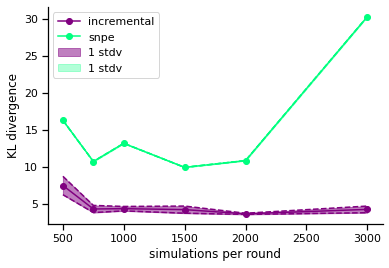

In [19]:
sns.set_context('notebook')
#sns.set_context('talk')

plt.plot(num_simulations_list, mean_incremental, '-o',label='incremental', color='purple')
plt.plot(num_simulations_list, mean_snpe, '-o', label='snpe', color='springgreen')

plt.plot(num_simulations_list, upper_incremental, '--', color='purple')
plt.plot(num_simulations_list, upper_snpe, '--',  color='springgreen')

plt.plot(num_simulations_list, lower_incremental, '--',  color='purple')
plt.plot(num_simulations_list, lower_snpe, '--',  color='springgreen')


plt.fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='purple', alpha=0.5,  label='1 stdv')
plt.fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='springgreen', alpha=0.3, label='1 stdv')


plt.legend()



plt.xlabel('simulations per round')
plt.ylabel('KL divergence')

sns.despine()
sns.despine()

